In [1]:
!if [ -d HSE ]; then rm -Rf HSE; fi
!git clone https://github.com/Tikhon239/HSE
!cp -a /content/HSE/BayesML/DDPM/* .

Cloning into 'HSE'...
remote: Enumerating objects: 2842, done.
remote: Counting objects: 100% (2842/2842), done.
remote: Compressing objects: 100% (2578/2578), done.
remote: Total 2842 (delta 243), reused 2664 (delta 182), pack-reused 0
Receiving objects: 100% (2842/2842), 45.46 MiB | 9.62 MiB/s, done.
Resolving deltas: 100% (243/243), done.
Checking out files: 100% (2425/2425), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install wandb
!pip3 install ml_collections

In [ ]:
!python3 train_ddpm_cont.py

wandb: Currently logged in as: shytea (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/wandb/run-20220413_192453-brkz0jzs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ddpm_cont
wandb: ⭐️ View project at https://wandb.ai/shytea/sde
wandb: 🚀 View run at https://wandb.ai/shytea/sde/runs/brkz0jzs
 56% 2794/5000 [1:07:04<49:20,  1.34s/it]wandb: Network error (ReadTimeout), entering retry loop.
100% 5000/5000 [2:01:00<00:00,  1.45s/it]

wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        loss/train ██▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: loss/valid_loader █▁▁▁▁▁▁▁▁▁
wandb:          lr/train ▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
wandb: 
wandb: Run summary:
wandb:        loss/train 18.64536
wandb: loss/valid_loader 16.84673
wandb:          lr/

In [7]:
!python3 train_noisy_classifier.py

wandb: Currently logged in as: shytea (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /content/wandb/run-20220413_220400-36otqmtz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run noisy_classifier
wandb: ⭐️ View project at https://wandb.ai/shytea/sde
wandb: 🚀 View run at https://wandb.ai/shytea/sde/runs/36otqmtz
 60% 2999/5000 [25:55<04:17,  7.76it/s]wandb: Network error (ReadTimeout), entering retry loop.
100% 5000/5000 [49:18<00:00,  1.69it/s]

wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy/valid ▆▆█▃▃█▅█▆▁
wandb: cross_entropy/train █▅▃▃▄▃▃▃▂▃▃▄▄▂▃▂▁▂▂▁▃▃▃▁▁▂▃▃▂▃▂▃▁▆▂▂▂▄▃▂
wandb: cross_entropy/valid ▄▅▄▅▇▃▅▁▃█
wandb: 
wandb: Run summary:
wandb:      accuracy/valid 0.3097
wandb: cross_entropy/train 1.10964
wandb: cross_entropy/valid 2.00534
wand

In [49]:
import torch
import wandb
import torchvision

import numpy as np

from data_generator import DataGenerator
from default_mnist_config import create_default_mnist_config
from diffusion import DiffusionRunner
from models.classifier import ResNet, ResidualBlock, ConditionalResNet

from matplotlib import pyplot as plt

In [50]:
unconditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)

In [51]:
device = torch.device('cuda')
classifier_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
noisy_classifier = ConditionalResNet(**classifier_args)
noisy_classifier.to(device)

noisy_classifier.load_state_dict(torch.load('./drive/MyDrive/ddpm_checkpoints/classifier.pth'))

clean_classifier = ResNet(**classifier_args)
clean_classifier.to(device)

clean_classifier.load_state_dict(torch.load('./drive/MyDrive/ddpm_checkpoints/clean_classifier.pth'))

<All keys matched successfully>

#### Создайте два семплемера картинок, безусловный и условный с методом .set_classifier

In [52]:
def get_pred_labels(images_normed: torch.Tensor):
    """
    predict labels for normed images 
    [-1, 1]
    """
    logits = clean_classifier(images_normed)

    return torch.argmax(logits, dim=1)


def calc_acc_clean_classifier(images_normed: torch.Tensor, labels: torch.Tensor):
    """
    calculate accuracy using clean classifier
    """
    pred_labels = get_pred_labels(images_normed)
    accuracy = (pred_labels == labels).sum()

    return accuracy / labels.shape[0]


def sample_images(diff_process, labels=None):
    images_tensor = diff_process.sample_images(batch_size=100, labels=labels)
    images_cpu = images_tensor.cpu()
    grid = torchvision.utils.make_grid(images_cpu, nrow=10).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)

    plt.imshow(grid)
    plt.show()
    return images_tensor


def cond_print_and_calc_acc(conditional_diffusion, class_num: int):
    labels = class_num*torch.ones(100).long().to(device)
    images_tensor = sample_images(conditional_diffusion, labels)
    acc = calc_acc_clean_classifier((images_tensor - 127.5)/ 127.5, labels=labels)
    print(f'Accuracy for {class_num}: {acc.item()}')
    return images_tensor


class Sampler:
    def __init__(self, diff_process):
        self.diff_process = diff_process
    
    def __call__(self):
        sample_images(self.diff_process)


class CSampler(Sampler):
    def __init__(self, diff_process, classifier, T):
        super().__init__(diff_process)
        self.set_classifier(classifier, T)

    def set_classifier(self, classifier, T):
        self.diff_process.set_classifier(classifier, T=T)

    def __call__(self, labels):
        sample_images(self.diff_process, labels)

    def calc_acc(self, classes=range(10)):
        for class_num in classes:
            cond_print_and_calc_acc(self.diff_process, class_num)

#### Посемплируйте наборы картинок всех классов обоими способами, изменить температуру можно с помощью повторного .set_classifier

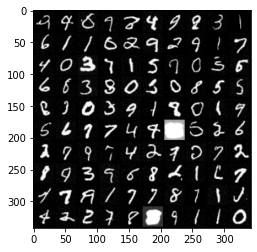

In [53]:
sampler = Sampler(unconditional_diffusion)
sampler()

In [54]:
labels = np.tile(np.arange(10), (10, 1))
labels = torch.Tensor(labels).to(device).long().view(-1)

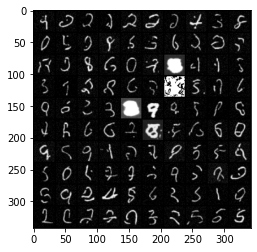

In [55]:
csampler = CSampler(unconditional_diffusion, noisy_classifier, T=1.)
csampler(labels)

In [ ]:
csampler.calc_acc([0])

In [ ]:
csampler.set_classifier(noisy_classifier, T=10.)
csampler(labels)

In [ ]:
csampler.calc_acc([0])

In [ ]:
csampler.set_classifier(noisy_classifier, T=0.1)
csampler(labels)

In [ ]:
csampler.calc_acc([0])

> Как сильно влияет температура на отличимость семплов при условной генерации? Продеменстрируйте для разных T свои выводы.



> Какое качество получается у чистого классификатора при условной генерации? Попробуйте оценить на глаз качество чистого классификатора для безусловной генерации, объясните свои выводы.
